In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dask
import dask.array as da
import xarray as xr

import toolbox_scs as tb
from toolbox_scs.routines.boz import load_dssc_module
from extra_data import open_run
from itertools import combinations
from itertools import repeat
from dask.distributed import Client, progress
from dask_jobqueue import SLURMCluster

import pandas as pd
from datetime import date
from tqdm.notebook import tqdm
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (14,8)
mpl.rcParams['font.size'] = 20

from os.path import basename, exists

from glob import glob
from pathlib import Path
from lmfit import Model, Parameters
from scipy.special import gamma, factorial, loggamma
import re

import sys

In [2]:
current =    [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]
runNB =      [70,  71,  73,  74,  76,  77,  79,  80,  82]
modules = [15, 0, 8, 7]
proposalNB = 2884

In [3]:
files = sorted(glob('./calculated_statistics/*.h5'), key = lambda x: int(re.findall(r'\d+', x)[-2]))
files

['./calculated_statistics/r70m0_0.h5',
 './calculated_statistics/r70m0_1.h5',
 './calculated_statistics/r70m0_2.h5',
 './calculated_statistics/r70m0_3.h5',
 './calculated_statistics/r70m0_4.h5',
 './calculated_statistics/r70m0_5.h5',
 './calculated_statistics/r70m0_6.h5',
 './calculated_statistics/r70m0_7.h5',
 './calculated_statistics/r70m0_8.h5',
 './calculated_statistics/r70m0_9.h5',
 './calculated_statistics/r70m0_10.h5',
 './calculated_statistics/r70m0_11.h5',
 './calculated_statistics/r70m0_12.h5',
 './calculated_statistics/r70m0_13.h5',
 './calculated_statistics/r70m0_14.h5',
 './calculated_statistics/r70m0_15.h5',
 './calculated_statistics/r70m0_16.h5',
 './calculated_statistics/r70m0_17.h5',
 './calculated_statistics/r70m0_18.h5',
 './calculated_statistics/r70m0_19.h5',
 './calculated_statistics/r70m0_20.h5',
 './calculated_statistics/r70m0_21.h5',
 './calculated_statistics/r70m0_22.h5',
 './calculated_statistics/r70m0_23.h5',
 './calculated_statistics/r70m0_24.h5',
 './calcul

In [4]:
file = files[0]
ds = xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:      (train: 300, pulse_separation: 200, k_photons: 100, unique_pairs: 200, count: 200)
Coordinates:
  * train        (train) int64 0 1 2 3 4 5 6 7 ... 293 294 295 296 297 298 299
Dimensions without coordinates: pulse_separation, k_photons, unique_pairs, count
Data variables:
    Pk           (train, pulse_separation, k_photons, unique_pairs) float64 ...
    group        (train) int64 ...
    k_bar        (train, pulse_separation, unique_pairs) float64 ...
    roi          (train) int64 ...
    valid_pairs  (train, count) int64 ...
Attributes:
    current:  0
    module:   0
    run:      70

In [6]:
%%time
prob_all = ds['Pk'].to_numpy()
k_bar_all = ds['k_bar'].to_numpy()

CPU times: user 1.65 ms, sys: 495 µs, total: 2.15 ms
Wall time: 1.54 ms


# single train

In [7]:
def neg_binom(k_bar, k, M):
    nb = (gamma( k + M ) / gamma( M ) / factorial( k ) ) * \
    ( ( k_bar / ( k_bar + M ) ) ** k ) * ( ( M / ( k_bar + M ) ) ** M)
    return nb

model = Model(neg_binom, independent_vars=['k_bar', 'k'])
params = Parameters()
params.add('M', value=4, min=0.1, max=150)

pulse_separation = 1
train_index = 0
min_k = 1
max_k = 10

y = prob_all[train_index, pulse_separation, min_k:max_k+1, :]
x = np.repeat(np.expand_dims(k_bar_all[train_index, pulse_separation, :], axis=-1), len(y), axis=-1).T
k = np.outer(np.arange(min_k, max_k+1), np.ones(len(y.T))).astype(int)

out = model.fit(data=y, k_bar=x, k=k, **params, nan_policy='omit')

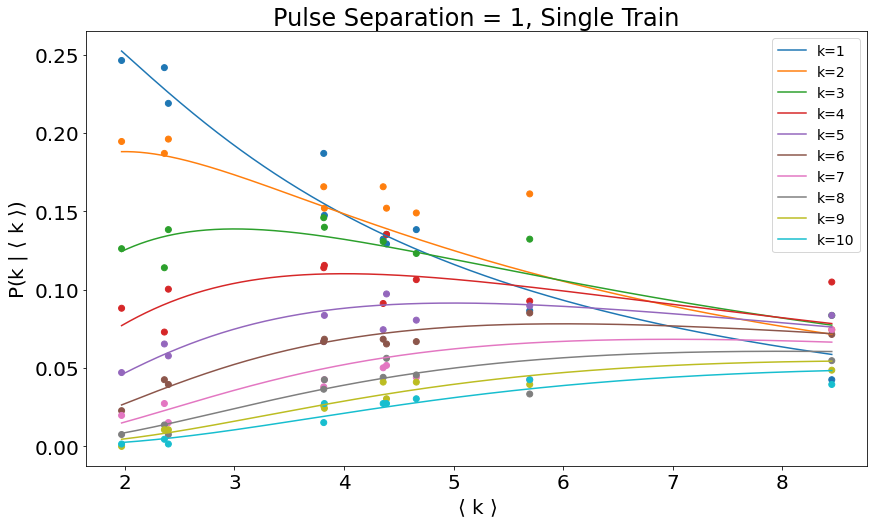

In [8]:
plt.figure()
plt.scatter(x.ravel(), y.ravel(), c=[f'C{k_-1}' for k_ in k.ravel()])

xx = np.linspace(np.nanmin(x), np.nanmax(x), 1000)
for kk in np.arange(min_k, max_k + 1):
    fit = neg_binom(xx, kk, out.best_values['M'])
    plt.plot(xx, fit, label=f'k={kk}')
    
plt.title(f'Pulse Separation = {pulse_separation}, Single Train')
plt.xlabel(r'$\langle$ k $\rangle$')
plt.ylabel(r'P(k | $\langle$ k $\rangle$)')
plt.legend(fontsize=14)
plt.show()

In [9]:
model = Model(neg_binom, independent_vars=['k_bar', 'k'])
params = Parameters()
params.add('M', value=4, min=0.1, max=150)
min_k = 1
max_k = 10

delays = []
contrasts = []
contrasts_err = []
for p_sep, pulse_separation in tqdm(enumerate(range(prob_all.shape[1])), total=prob_all.shape[1], desc='Fitting Neg. Binom.'):
    y = prob_all[train_index, pulse_separation, min_k:max_k+1, :]
    x = np.repeat(np.expand_dims(k_bar_all[train_index, pulse_separation, :], axis=-1), len(y), axis=-1).T
    k = np.outer(np.arange(min_k, max_k+1), np.ones(len(y.T))).astype(int)

    if np.isnan(y).all():
        continue

    out = model.fit(data=y, k_bar=x, k=k, **params, nan_policy='omit')
    delays.append(p_sep)
    
    contrast = 1/np.sqrt(out.best_values['M'])
    contrast_err = 0.5 * contrast * out.params['M'].stderr / contrast
    
    contrasts.append(contrast)
    contrasts_err.append(contrast_err)

Fitting Neg. Binom.:   0%|          | 0/200 [00:00<?, ?it/s]

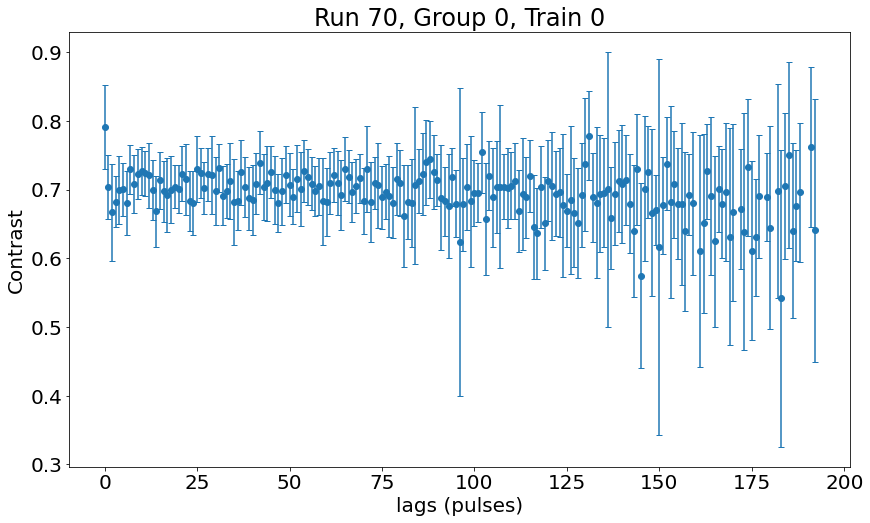

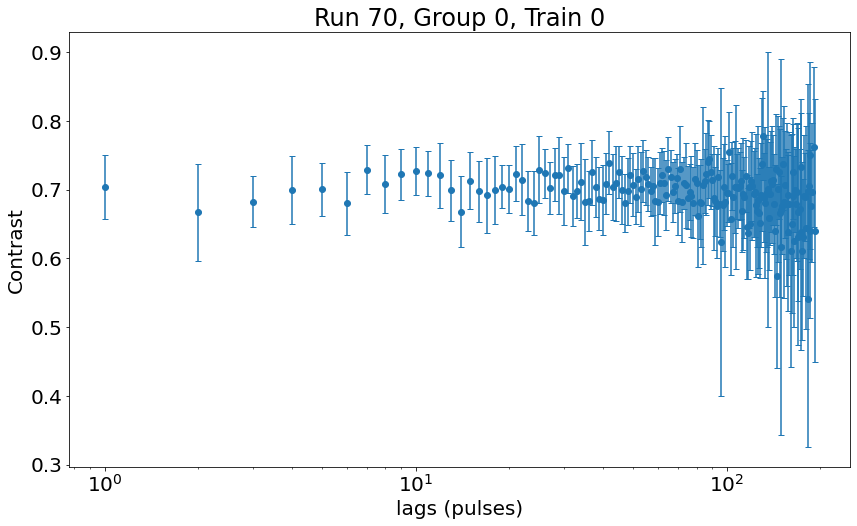

In [11]:
plt.figure()
plt.errorbar(delays, contrasts, contrasts_err, fmt='o', capsize=3,)
plt.title('Run 70, Group 0, Train 0')
plt.ylabel('Contrast')
plt.xlabel('lags (pulses)')
plt.show()

plt.figure()
plt.errorbar(delays, contrasts, contrasts_err, fmt='o', capsize=3,)
plt.semilogx()
plt.title('Run 70, Group 0, Train 0')
plt.ylabel('Contrast')
plt.xlabel('lags (pulses)')
plt.show()

# single group

In [13]:
model = Model(neg_binom, independent_vars=['k_bar', 'k'])
params = Parameters()
params.add('M', value=4, min=0.1, max=150)
min_k = 1
max_k = 10


contrasts = np.empty(prob_all.shape[:2])*np.nan
contrasts_err = np.empty(prob_all.shape[:2])*np.nan

for train_index, train in tqdm(enumerate(prob_all), total=len(prob_all), desc='Calculating Contrast Curves'):
    for p_sep, pulse_separation in enumerate(range(prob_all.shape[1])):
        y = prob_all[train_index, pulse_separation, min_k:max_k+1, :]
        x = np.repeat(np.expand_dims(k_bar_all[train_index, pulse_separation, :], axis=-1), len(y), axis=-1).T
        k = np.outer(np.arange(min_k, max_k+1), np.ones(len(y.T))).astype(int)

        if np.isnan(y).all():
            continue

        out = model.fit(data=y, k_bar=x, k=k, **params, nan_policy='omit')

        contrast = 1/np.sqrt(out.best_values['M'])
        contrast_err = 0.5 * contrast * out.params['M'].stderr / contrast

        contrasts[train_index, p_sep] = contrast
        contrasts_err[train_index, p_sep] = contrast_err

Calculating Contrast Curves, Train:   0%|          | 0/300 [00:00<?, ?it/s]

In [14]:
contrasts.shape

(300, 200)

In [17]:
len(delays)

187

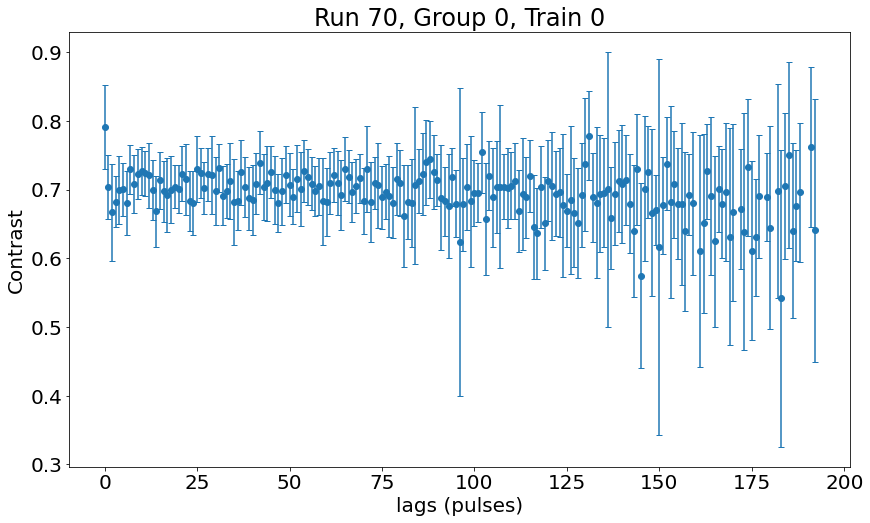

In [19]:
plt.figure()
plt.errorbar(np.arange(len(contrasts[0])), contrasts[0], contrasts_err[0], fmt='o', capsize=3,)
plt.title('Run 70, Group 0, Train 0')
plt.ylabel('Contrast')
plt.xlabel('lags (pulses)')
plt.show()

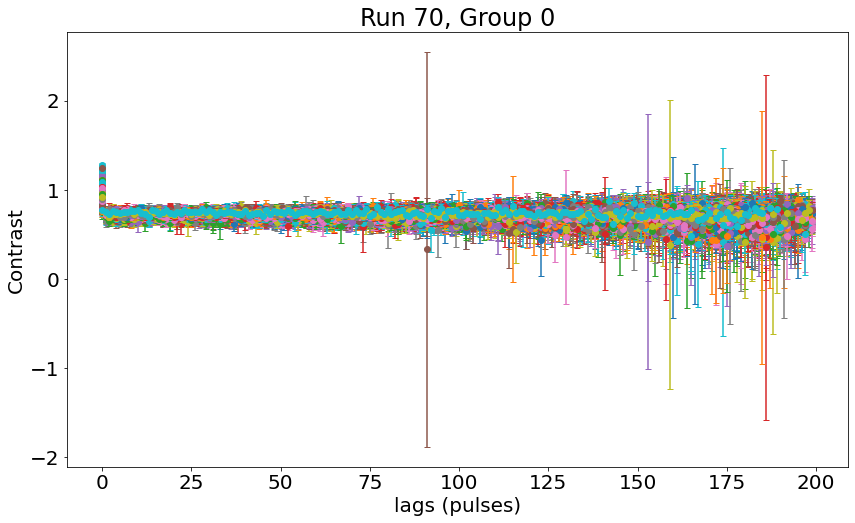

In [35]:
delays = np.arange(len(contrasts[0]))

plt.figure()
for c, ce in zip(contrasts, contrasts_err):
    plt.errorbar(delays, c, ce, fmt='o', capsize=3,)
    
plt.title('Run 70, Group 0')
plt.ylabel('Contrast')
plt.xlabel('lags (pulses)')
plt.show()

In [42]:
from scipy.stats import gaussian_kde
x = np.outer(np.ones(300), delays).ravel()
y = contrasts.ravel()

x = x[~np.isnan(y)]
y = y[~np.isnan(y)]

xy = np.vstack([x, y])
z = gaussian_kde(xy)(xy)

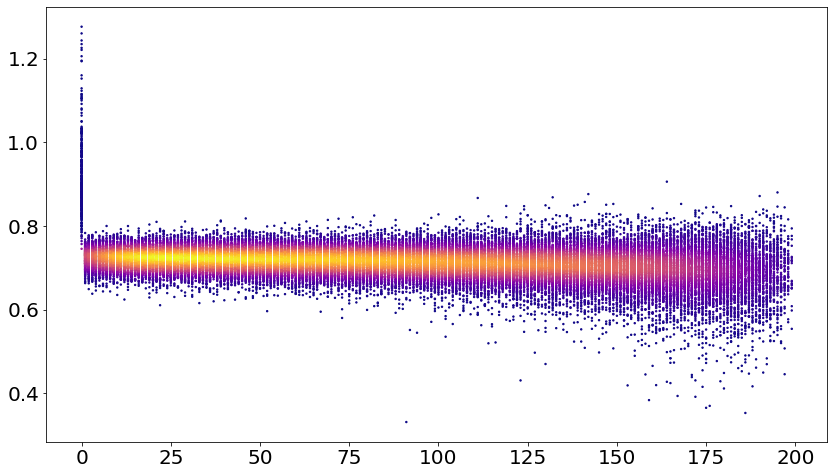

In [48]:
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=2, cmap='plasma')
plt.show()

In [89]:
def fit_func(t, A, tau, beta, c):
    return A * np.exp( -( t / tau) ** beta ) + c

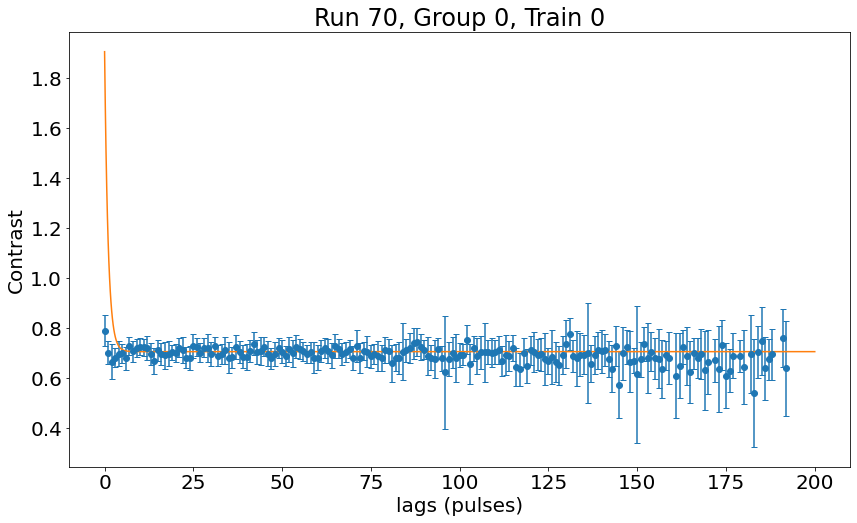

In [116]:
xx = np.linspace(0,200, 1000)
plt.figure()
plt.errorbar(np.arange(len(contrasts[0])), contrasts[0], contrasts_err[0], fmt='o', capsize=3,)
plt.plot(xx, fit_func(xx, 1.2, 1, 1, 0.707))
plt.title('In')
plt.ylabel('Contrast')
plt.xlabel('lags (pulses)')
plt.show()

In [111]:
mod = Model(fit_func)
params = mod.make_params(A=1, tau=1, beta=1, c=0.707)
params['beta'].vary = False
params['beta'].min = 0.5
params['beta'].max = 3
params['tau'].min = 1e-3
params['tau'].max = 10
params['c'].min = 0.5

out = mod.fit(y, t=x, params=params)

In [112]:
out

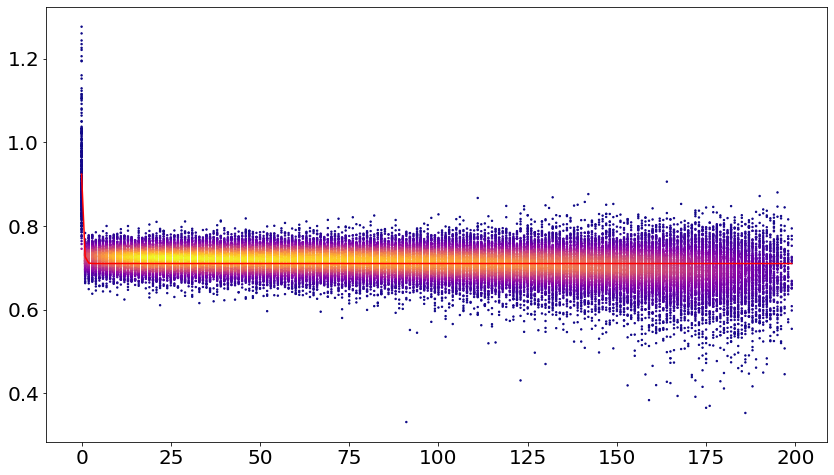

In [113]:
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=2, cmap='plasma')
plt.plot(xx, fit_func(xx,**out.best_values), 'r')
plt.show()

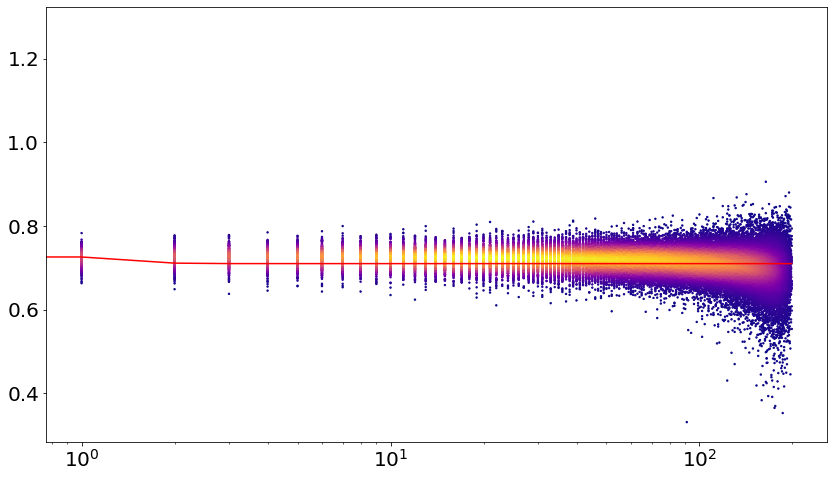

In [115]:
fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=2, cmap='plasma')
plt.plot(xx, fit_func(xx,**out.best_values), 'r')
plt.semilogx()
plt.show()